In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from utils.preprocessing import create_time_matrix, create_caregivers_df, create_tasks_df, create_clients_df

caregivers = create_caregivers_df('data/raw/caregivers.csv')

tasks = create_tasks_df('data/raw/hemtjanst_tasks.csv', only_client_tasks=True)

clients = create_clients_df('data/raw/clients.csv')

drive_time_matrix = create_time_matrix('data/raw/duration_matrix_DRIVE.csv')
walk_time_matrix = create_time_matrix('data/raw/duration_matrix_WALK.csv')
bicycle_time_matrix = create_time_matrix('data/raw/duration_matrix_BICYCLE.csv')

In [2]:
# Test1: Subset with only caregivers 33, 949, 1108 and their tasks
test1_subset = [33, 949, 1108]
caregivers_test1 = caregivers.loc[test1_subset]
tasks_test1 = tasks[tasks['PlannedCaregiverID'].isin(test1_subset)]

print(f"Number of caregivers in subset: {len(caregivers_test1)}")
print(f"Number of tasks assigned to subset caregivers: {len(tasks_test1)}")

# Test2: Subset with only first 10 caregivers that use car as mode of transport
car_caregivers = caregivers[caregivers['ModeOfTransport'] == 'car']
caregivers_test2 = car_caregivers.head(10)
tasks_test2 = tasks[tasks['PlannedCaregiverID'].isin(caregivers_test2.index)]

print(f"Number of caregivers in subset: {len(caregivers_test2)}")
print(f"Number of tasks assigned to subset caregivers: {len(tasks_test2)}")

Number of caregivers in subset: 3
Number of tasks assigned to subset caregivers: 27
Number of caregivers in subset: 10
Number of tasks assigned to subset caregivers: 86


In [ ]:
from models.basic_flexible_model import BasicFlexibleModel
from models.basic_fixed_model import BasicFixedModel
from models.break_fixed_model import BreakFixedModel
model_type = BasicFixedModel
model_caregivers = caregivers
model_tasks = tasks

model = model_type(model_caregivers, model_tasks, clients, drive_time_matrix, walk_time_matrix, bicycle_time_matrix)
model.build()
model.optimize()

Model built.
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 125 rows, 2277 columns and 8121 nonzeros
Model fingerprint: 0x5ea7a949
Variable types: 6 continuous, 2271 integer (2271 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+02]
Presolve removed 34 rows and 1594 columns
Presolve time: 0.03s
Presolved: 91 rows, 683 columns, 1889 nonzeros
Variable types: 0 continuous, 683 integer (678 binary)
Found heuristic solution: objective 1503.0500000

Root relaxation: cutoff, 246 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      1503.05000 1503.05000 

<gurobi.Model MIP instance HomeCare: 125 constrs, 2277 vars, Parameter changes: Username=(user-defined), LicenseID=2634432>

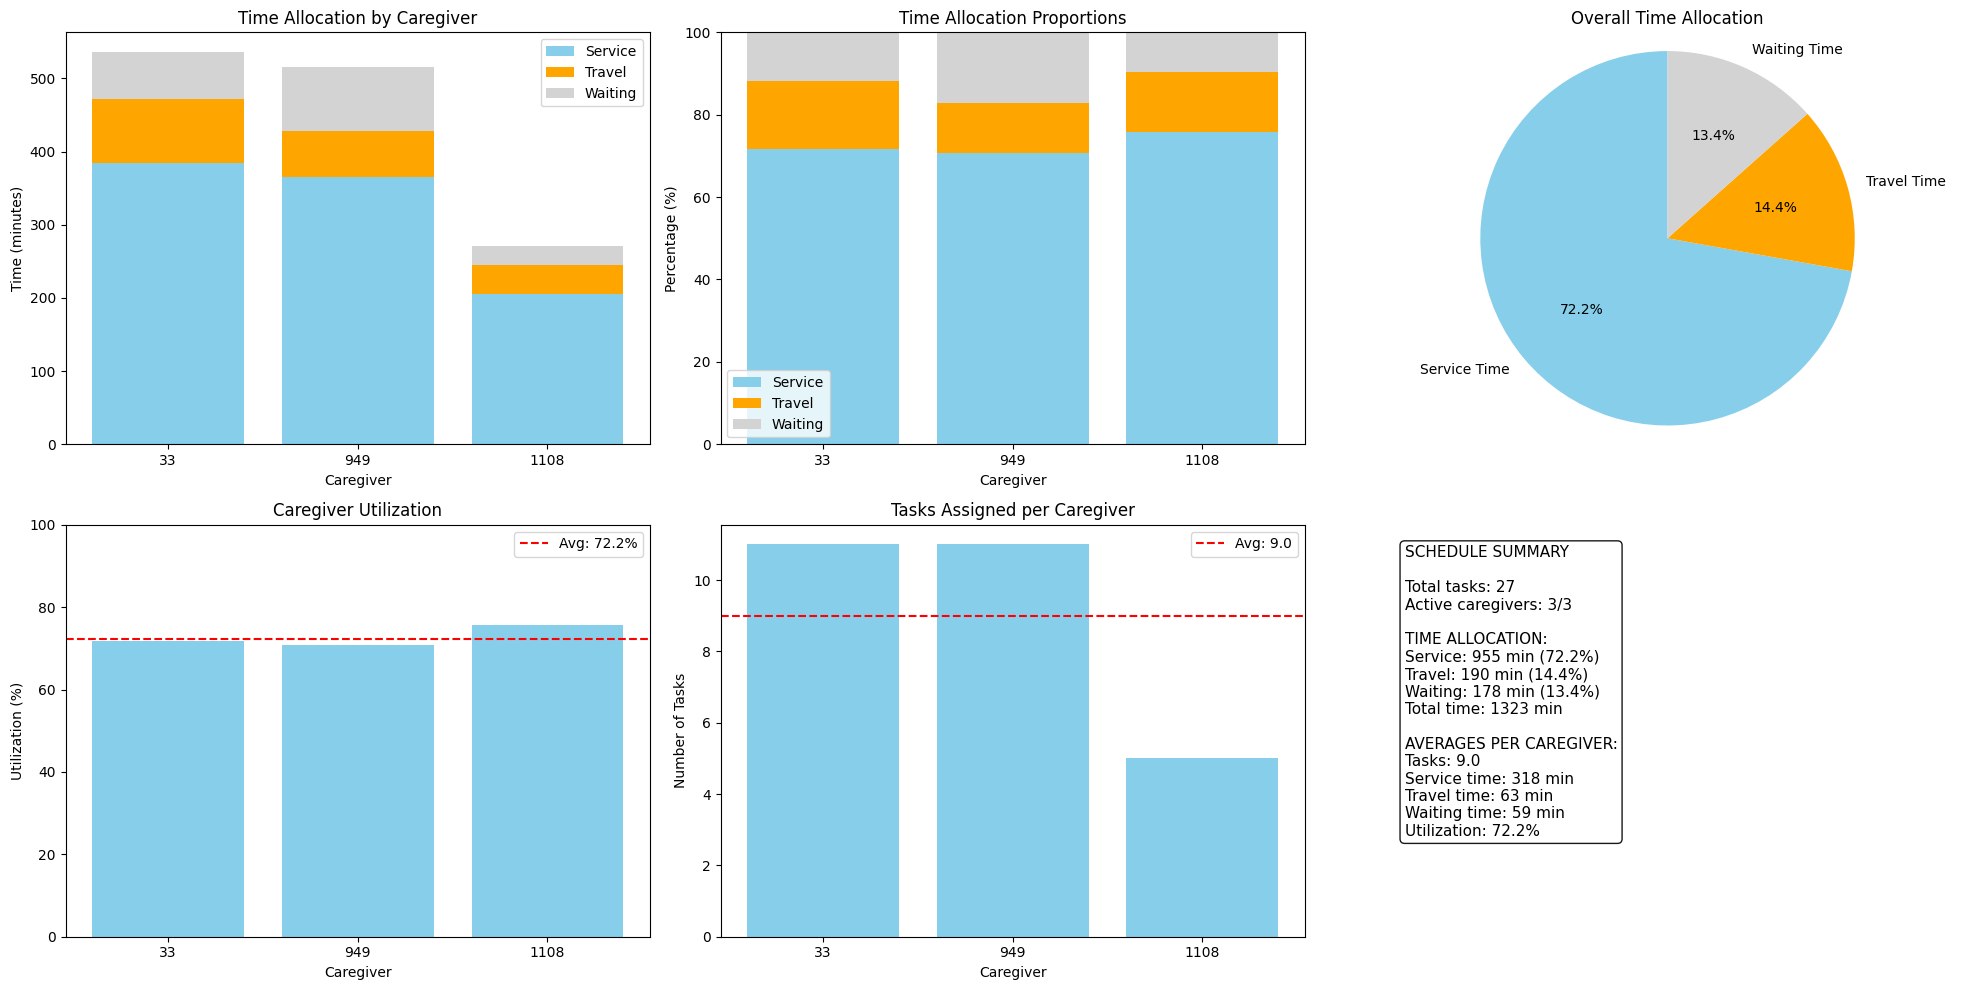

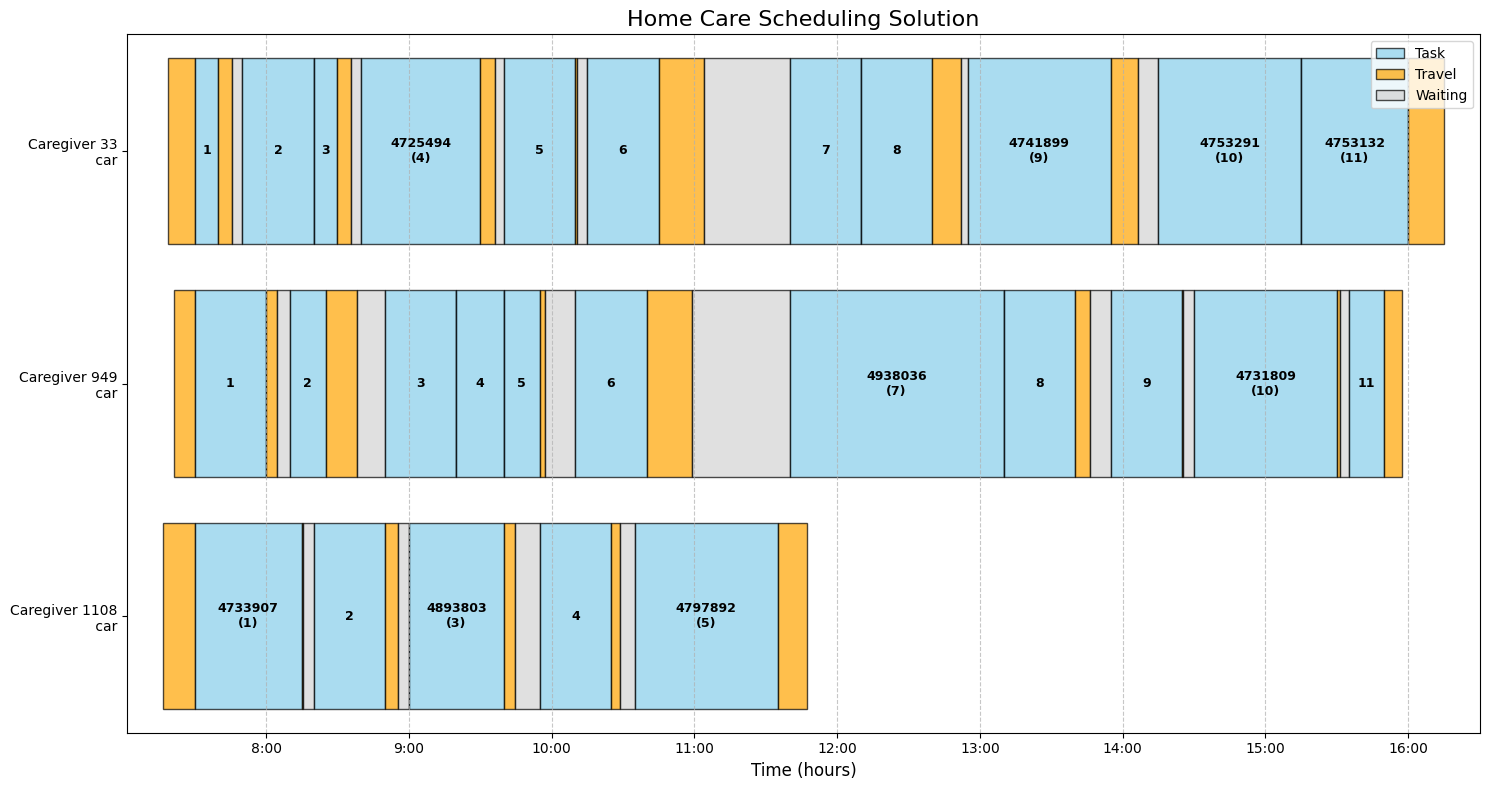

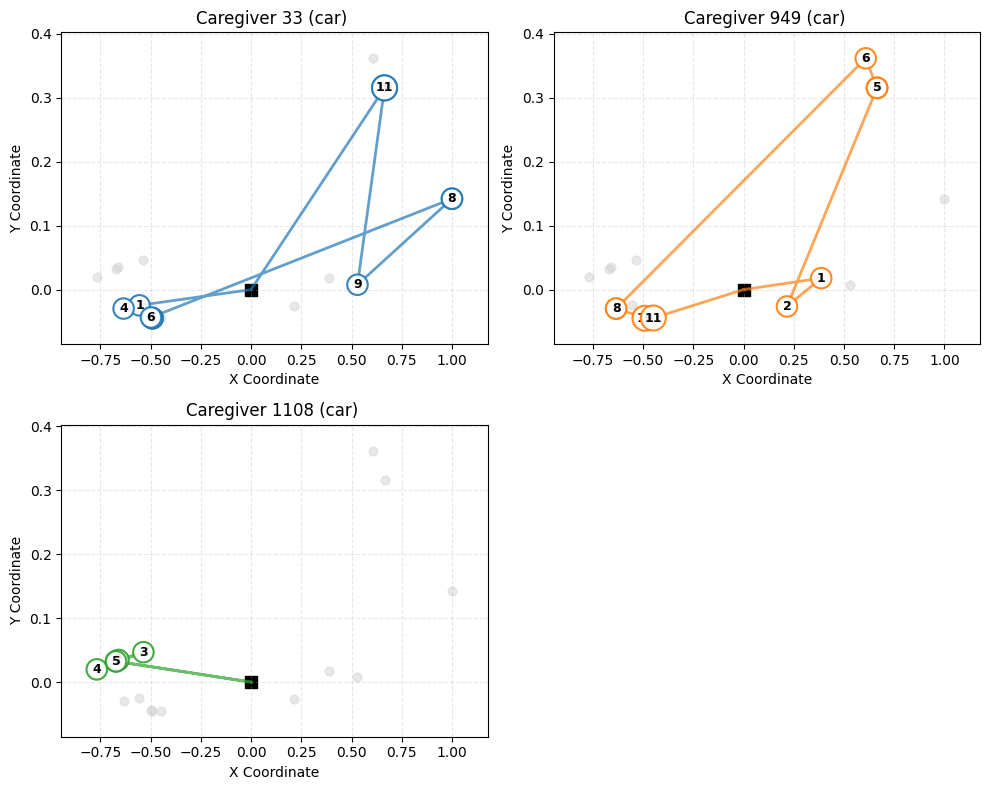

In [8]:
from utils.visualization import visualize_schedule, visualize_metrics, visualize_routes

model.get_solution()

visualize_metrics(model, display_mode='dashboard');
visualize_schedule(model);
visualize_routes(model, caregiver_ids=None, subplot_mode=True);